In [1]:
import matplotlib
import uproot, uproot3
import numpy
import awkward
import numba
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import pandas as pd
from tqdm import trange
import ROOT
import os,sys
from array import array


from Lumi import *
from Ratio_Plot import *
from TDR_Style import *

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


Welcome to JupyROOT 6.24/06


In [2]:
def AddHist_data(file, hist, ptrange, isbarrel):
    branches = uproot.open(file+':Events').arrays(['More_than_three_tight_lep','HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL','HLT_Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL','HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ','HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8','HLT_Ele32_WPTight_Gsf','HLT_IsoMu24','photon_sieie','photon_vidNestedWPBitmap','photon_eta','photon_pt','photon_pfRelIso03_chg'], library='pd')
    
    HLT_SingleMuon = branches.loc[:,'HLT_IsoMu24'] == True
    HLT_DoubleMuon = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8'] == True
    HLT_EGamma = branches.loc[:,'HLT_Ele32_WPTight_Gsf'] == True
    HLT_DoubleEG = branches.loc[:,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL'] == True
    HLT_MuonEG1 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'] == True
    HLT_MuonEG2 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL'] == True
    
    if 'SingleMuon' in file:
        arrays = branches.loc[HLT_SingleMuon, :].copy()
    elif 'DoubleMuon' in file:
        arrays = branches.loc[~HLT_SingleMuon & HLT_DoubleMuon, :].copy()
#         2018 is special
    elif 'EGamma' in file:
        arrays = branches.loc[~HLT_SingleMuon & ~HLT_DoubleMuon &   (HLT_EGamma | HLT_DoubleEG) ,:].copy()
    elif 'MuonEG' in file:
        arrays = branches.loc[~HLT_SingleMuon & ~HLT_DoubleMuon &  ~(HLT_EGamma | HLT_DoubleEG) & (HLT_MuonEG1 | HLT_MuonEG2),:].copy()
    else:
        arrays = branches.loc[HLT_SingleMuon | HLT_DoubleMuon |  HLT_EGamma | HLT_DoubleEG | HLT_MuonEG1 | HLT_MuonEG2,:].copy()
        
    
    if isbarrel == 1:
        eta_cut = abs(arrays.loc[:,'photon_eta']) < 1.4442
#         chg_cut = (arrays.loc[:,'photon_pfRelIso03_chg']*arrays.loc[:,'photon_pt']) < 1.141
    elif isbarrel == 0:
        eta_cut = abs((arrays.loc[:,'photon_eta']) > 1.566) & abs((arrays.loc[:,'photon_eta']) < 2.5)
#         chg_cut = (arrays.loc[:,'photon_pfRelIso03_chg']*arrays.loc[:,'photon_pt']) < 1.051
        
    mask_mediumID_withoutsieie = (1<<1) | (1<<3) | (1<<5) | (1<<9) | (1<<11) | (1<<13)
    arrays['mediumID'] = arrays['photon_vidNestedWPBitmap'] & mask_mediumID_withoutsieie
    arrays = arrays.loc[arrays.loc[:,'mediumID'] == mask_mediumID_withoutsieie, :]
    
    three_lep_cut = arrays.loc[:,'More_than_three_tight_lep'] == 0
    pt_cut = (arrays.loc[:,'photon_pt'] >= ptrange[0]) & (arrays.loc[:,'photon_pt'] < ptrange[1]) 
    arrays = arrays.loc[pt_cut & eta_cut & three_lep_cut,:]
    
    for i in trange(0, len(arrays['photon_sieie']), desc=f'fill sigma ieta ieta for {file}'):
        hist.Fill(float(arrays['photon_sieie'].values[i]))
    
    
def AddHist_mcTruth(file, hist, ptrange, isbarrel, xsec, lumi):
    branches = uproot.open(file+':Events').arrays(['Generator_weight','More_than_three_tight_lep','HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL','HLT_Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL','HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ','HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8','HLT_Ele32_WPTight_Gsf','HLT_IsoMu24','photon_sieie','photon_vidNestedWPBitmap','photon_genPartFlav','photon_eta','photon_pt','photon_pfRelIso03_chg'], library='pd')
    true_events = uproot.open(file)['nEventsGenWeighted'].values()[0]
    
    HLT_SingleMuon = branches.loc[:,'HLT_IsoMu24'] == True
    HLT_DoubleMuon = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8'] == True
    HLT_EGamma = branches.loc[:,'HLT_Ele32_WPTight_Gsf'] == True
    HLT_DoubleEG = branches.loc[:,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL'] == True
    HLT_MuonEG1 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'] == True
    HLT_MuonEG2 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL'] == True
    
    arrays = branches.loc[HLT_SingleMuon | HLT_DoubleMuon |  HLT_EGamma | HLT_DoubleEG | HLT_MuonEG1 | HLT_MuonEG2,:].copy()
    
    if isbarrel == 1:
        eta_cut = abs(arrays.loc[:,'photon_eta']) < 1.4442
    elif isbarrel == 0:
        eta_cut = abs((arrays.loc[:,'photon_eta']) > 1.566) & abs((arrays.loc[:,'photon_eta']) < 2.5)
        
    mask_mediumID_withoutsieie = (1<<1) | (1<<3) | (1<<5) | (1<<9) | (1<<11) | (1<<13)
    arrays['mediumID'] = arrays['photon_vidNestedWPBitmap'] & mask_mediumID_withoutsieie
    arrays = arrays.loc[arrays.loc[:,'mediumID'] == mask_mediumID_withoutsieie, :]
    
    three_lep_cut = arrays.loc[:,'More_than_three_tight_lep'] == 0
    pt_cut = (arrays.loc[:,'photon_pt'] >= ptrange[0]) & (arrays.loc[:,'photon_pt'] < ptrange[1]) 
    gen_cut = arrays.loc[:,'photon_genPartFlav'] != 0
    arrays = arrays.loc[pt_cut & eta_cut & three_lep_cut & gen_cut,:]
    
    arrays['Generator_weight_sgn'] = arrays['Generator_weight'].apply(lambda x: 1 if x >= 0 else -1)
    arrays['true_weight'] = lumi * xsec * 1000 * arrays['Generator_weight_sgn'] / true_events
    
    for i in trange(0, len(arrays['photon_sieie']), desc=f'fill sigma ieta ieta for {file}'):
        hist.Fill(float(arrays['photon_sieie'].values[i]), float(arrays['true_weight'].values[i]))
        
    
def AddHist_dataFake(file, hist, ptrange, isbarrel):
    branches = uproot.open(file+':Events').arrays(['More_than_three_tight_lep','HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL','HLT_Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL','HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ','HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8','HLT_Ele32_WPTight_Gsf','HLT_IsoMu24','photon_sieie','photon_vidNestedWPBitmap','photon_eta','photon_pt','photon_pfRelIso03_chg'], library='pd')
    
    HLT_SingleMuon = branches.loc[:,'HLT_IsoMu24'] == True
    HLT_DoubleMuon = branches.loc[:,'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8'] == True
    HLT_EGamma = branches.loc[:,'HLT_Ele32_WPTight_Gsf'] == True
    HLT_DoubleEG = branches.loc[:,'HLT_Ele23_Ele12_CaloIdL_TrackIdL_IsoVL'] == True
    HLT_MuonEG1 = branches.loc[:,'HLT_Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ'] == True
    HLT_MuonEG2 = branches.loc[:,'HLT_Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL'] == True
    
    if 'SingleMuon' in file:
        arrays = branches.loc[HLT_SingleMuon, :].copy()
    elif 'DoubleMuon' in file:
        arrays = branches.loc[~HLT_SingleMuon & HLT_DoubleMuon, :].copy()
#         2018 is special
    elif 'EGamma' in file:
        arrays = branches.loc[~HLT_SingleMuon & ~HLT_DoubleMuon &   (HLT_EGamma | HLT_DoubleEG) ,:].copy()
    elif 'MuonEG' in file:
        arrays = branches.loc[~HLT_SingleMuon & ~HLT_DoubleMuon &  ~(HLT_EGamma | HLT_DoubleEG) & (HLT_MuonEG1 | HLT_MuonEG2),:].copy()
    else:
        arrays = branches.loc[HLT_SingleMuon | HLT_DoubleMuon |  HLT_EGamma | HLT_DoubleEG | HLT_MuonEG1 | HLT_MuonEG2,:].copy()
        
    if isbarrel == 1:
        eta_cut = abs(arrays.loc[:,'photon_eta']) < 1.4442
    elif isbarrel == 0:
        eta_cut = abs((arrays.loc[:,'photon_eta']) > 1.566) & abs((arrays.loc[:,'photon_eta']) < 2.5)
        
    chg_cut = ((arrays.loc[:,"photon_pfRelIso03_chg"]*arrays.loc[:,"photon_pt"]) > 4) & ((arrays.loc[:,"photon_pfRelIso03_chg"]*arrays.loc[:,"photon_pt"]) < 10)
    three_lep_cut = arrays.loc[:,'More_than_three_tight_lep'] == 0
    pt_cut = (arrays.loc[:,'photon_pt'] >= ptrange[0]) & (arrays.loc[:,'photon_pt'] < ptrange[1]) 
    arrays = arrays.loc[pt_cut & eta_cut & chg_cut & three_lep_cut,:]
    
    for i in trange(0, len(arrays['photon_sieie']), desc=f'fill sigma ieta ieta for {file}'):
        hist.Fill(float(arrays['photon_sieie'].values[i]))
        
# def FakeFraction_Fit(hist_data, hist_mcTruth, hist_dataFake):
    

In [3]:
xbins = 5
xleft = 0.01
xright = 0.06
ptrange = [20,50]

# 1: barrel
# 0: endcap
isbarrel = 0


hist_data = ROOT.TH1F("","",xbins,xleft,xright)
hist_mctruth = ROOT.TH1F("","",xbins,xleft,xright)
hist_datafake = ROOT.TH1F("","",xbins,xleft,xright)
hist_data.Sumw2()
hist_mctruth.Sumw2()
hist_datafake.Sumw2()

filelist_data = [
"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018A.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018B.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018C.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018D.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018A.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018B.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018C.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018D.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MuonEG_Run2018A.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MuonEG_Run2018B.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MuonEG_Run2018C.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MuonEG_Run2018D.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/SingleMuon_Run2018A.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/SingleMuon_Run2018B.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/SingleMuon_Run2018C.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/SingleMuon_Run2018D.root"
]

filelist_mc = [
"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/WZG_2018.root"
,"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/ZGToLLG_2018.root"
]

In [8]:
filelist_MC = {
    
   "ZGToLLG":
        {"name":"ZGToLLG",
        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/ZGToLLG_2018.root", 
        "xsec":55.48,
        "color":48},
    "WZG":
        {"name":"WZG",
        "path":"/eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/WZG_2018.root",
        "xsec":0.0384,
        "color":46},
}

In [5]:
for file in filelist_data:
    AddHist_data(file, hist_data, ptrange, isbarrel)

fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018A.root: 100%|██████████| 165/165 [00:00<00:00, 24684.70it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018B.root: 100%|██████████| 77/77 [00:00<00:00, 95692.27it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018C.root: 100%|██████████| 78/78 [00:00<00:00, 92182.51it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018D.root: 100%|██████████| 375/375 [00:00<00:00, 128649.11it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018A.root: 100%|██████████| 1349/1349 [00:00<00:00, 204456.03it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018B.root: 100%|██████████| 686/68

In [9]:
for file in filelist_MC:
    AddHist_mcTruth(filelist_MC[file]['path'], hist_mctruth, ptrange, isbarrel, filelist_MC[file]['xsec'], 59.7)

fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/ZGToLLG_2018.root: 100%|██████████| 48/48 [00:00<00:00, 4014.01it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/MC/WZG_2018.root: 100%|██████████| 182/182 [00:00<00:00, 74055.43it/s]


In [10]:
for file in filelist_data:
    AddHist_dataFake(file, hist_datafake, ptrange, isbarrel)

fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018A.root: 100%|██████████| 72/72 [00:00<00:00, 77892.67it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018B.root: 100%|██████████| 36/36 [00:00<00:00, 129609.39it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018C.root: 100%|██████████| 18/18 [00:00<00:00, 55269.01it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/DoubleMuon_Run2018D.root: 100%|██████████| 122/122 [00:00<00:00, 132669.20it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018A.root: 100%|██████████| 588/588 [00:00<00:00, 188666.67it/s]
fill sigma ieta ieta for /eos/home-j/jiwoong/SWAN_projects/Draw/Merged_file_FakePhoton_211128/EGamma_Run2018B.root: 100%|██████████| 325/325 [

Save hist

In [22]:
np.save("data_hist_dict.npy",{"EE_PT1":hist_data})
np.save("real_hist_dict.npy",{"EE_PT1":hist_mctruth})
np.save("fake_hist_dict.npy",{"EE_PT1":hist_datafake})
!ls

Combined_plot.ipynb  hist_dict_real.npy		    Ratio_Plot.py
data_hist_dict.npy   Lumi.py			    real_hist_dict.npy
Electron_channel     Merged_file		    Scale_PDF_Unc.ipynb
fake_hist_dict.npy   Merged_file_211028		    TDR_Style.py
hist_dict_data.npy   Merged_file_FakePhoton_211128  Template_Fit.ipynb
hist_dict_fake.npy   __pycache__		    Test_Fit.ipynb


Load hist

In [27]:
hist_data     = np.load("data_hist_dict.npy",allow_pickle=True)[()]['EE_PT1']
hist_mctruth  = np.load("real_hist_dict.npy",allow_pickle=True)[()]['EE_PT1']
hist_datafake = np.load("fake_hist_dict.npy",allow_pickle=True)[()]['EE_PT1']

### Start Fit

In [28]:
# Observable
sieie = ROOT.RooRealVar("sieie","sieie",xleft,xright)

# Import hist
data_hist = ROOT.RooDataHist("data_hist", "data with x(sieie)", ROOT.RooArgList(sieie), ROOT.RooFit.Import(hist_data))
TruePhotons_hist = ROOT.RooDataHist("TruePhotons_hist", "true photons MC with x(sieie)", ROOT.RooArgList(sieie), ROOT.RooFit.Import(hist_mctruth))
FakePhotons_hist = ROOT.RooDataHist("FakePhotons_hist", "fake photons data with x(sieie)", ROOT.RooArgList(sieie), ROOT.RooFit.Import(hist_datafake))

ndata = hist_data.GetSumOfWeights()

# Parameters
# TrueFraction = ROOT.RooRealVar("TrueFraction","fraction of true photons", 0, 1)
# FakeFraction = ROOT.RooRealVar("FakeFraction","fraction of fake photons", 0, 1)

ntrue = ROOT.RooRealVar("true number", "true number", 0.5*ndata, 0, ndata)
nfake = ROOT.RooRealVar("fake number", "fake number", 0.5*ndata, 0, ndata)

# PDF
true_pdf = ROOT.RooHistPdf("true_pdf", "truepdf", sieie, TruePhotons_hist)
fake_pdf = ROOT.RooHistPdf("fake_pdf", "fakepdf", sieie, FakePhotons_hist)

etrue_pdf = ROOT.RooExtendPdf("ntrue", "ntrue", true_pdf, ntrue)
efake_pdf = ROOT.RooExtendPdf("nfake", "nfake", fake_pdf, nfake)

fullpdf = ROOT.RooAddPdf("fullpdf", "true plus fake", ROOT.RooArgList(etrue_pdf, efake_pdf))

# Fit
fullpdf.fitTo(data_hist, ROOT.RooFit.SumW2Error(True), ROOT.RooFit.Extended(True))

chi2 = ROOT.RooChi2Var("chi2", "chi2", fullpdf, data_hist)
chi2ToNDF = chi2.getVal() / xbins


[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions have been identified as constant and will be precalculated and cached: (true_pdf,fake_pdf)
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (ntrue,nfake)
 **********
 **   25 **SET PRINT           1
 **********
 **********
 **   26 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 fake number   6.72650e+03  1.34530e+03    0.00000e+00  1.34530e+04
     2 true number   6.72650e+03  1.34530e+03    0.00000e+00  1.34530e+04
 **********
 **   27 **SET ERR         0.5
 **********
 **********
 **   28 **SET PRINT           1
 **********
 **********
 **   29 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **   30 **MIGRAD        1000           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW ST

### Plot1 : Berfore fit

59.7 fb^{-1} (13 TeV)


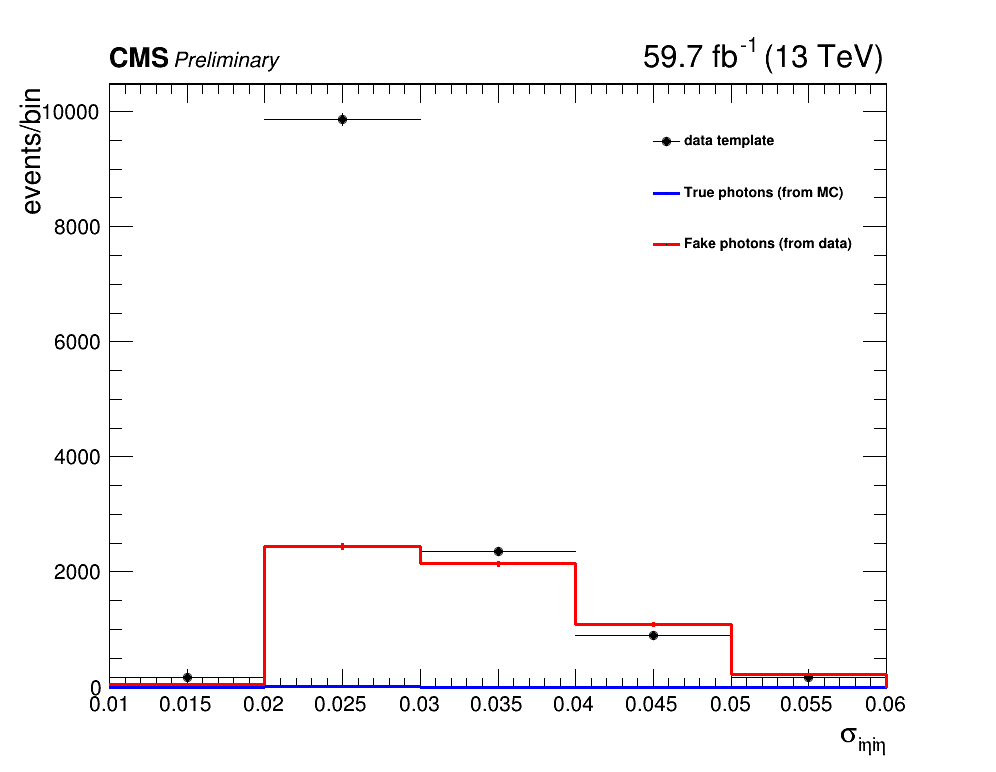

In [29]:
c1 = ROOT.TCanvas("","",1000,800)

hist_data.SetStats(False)
c1.Draw()
hist_data.GetXaxis().SetTitle("#sigma_{i#etai#eta}")
hist_data.GetYaxis().SetTitle("events/bin")
hist_data.Draw("ep")

hist_mctruth.SetMarkerStyle(0)
hist_mctruth.SetLineColor(4)
hist_mctruth.SetLineWidth(3)
hist_mctruth.Draw("HiST SAME e")

hist_datafake.SetMarkerStyle(0)
hist_datafake.SetLineColor(2)
hist_datafake.SetLineWidth(3)
hist_datafake.Draw("HiST SAME e")

legend = ROOT.TLegend(0.65, 0.65, 0.80, 0.85)
legend.SetBorderSize(0)
legend.SetFillColor(0)
legend.SetTextSize(0.020)
legend.SetLineWidth(1)
legend.SetLineStyle(0)
legend.AddEntry(hist_data,'data template')
legend.AddEntry(hist_mctruth,'True photons (from MC)')
legend.AddEntry(hist_datafake,'Fake photons (from data)')
legend.Draw("SAME")

# ROOT.gPad.SetLogy()
# ROOT.gPad.SetGrid()
CMS_lumi(c1, 0, 0)

### Plot2 : After fit

59.7 fb^{-1} (13 TeV)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(fullpdf) directly selected PDF components: (ntrue)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(fullpdf) indirectly selected PDF components: (true_pdf)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(fullpdf) directly selected PDF components: (nfake)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(fullpdf) indirectly selected PDF components: (fake_pdf)


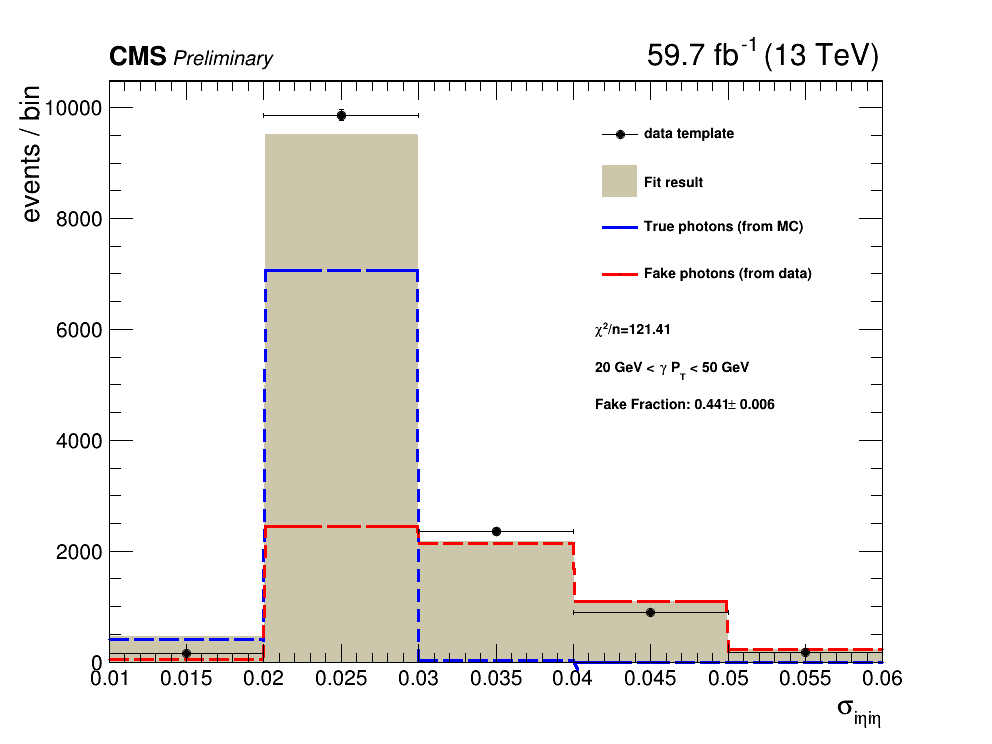

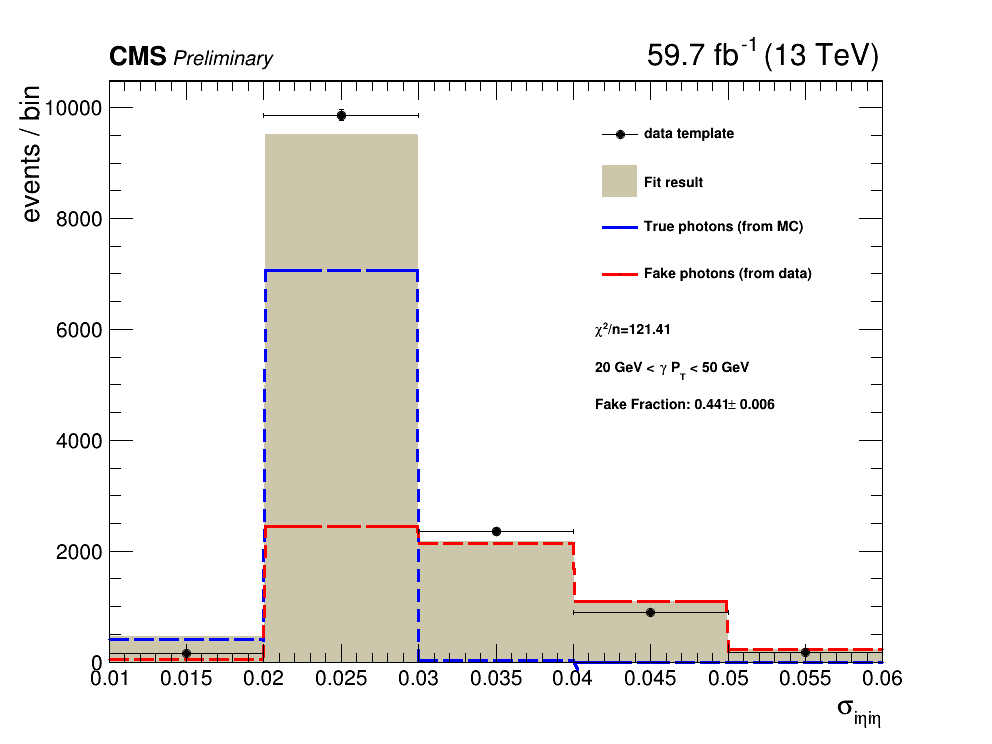

In [30]:
# Plot
if isbarrel == 1:
    region_mark = "Barrel"
else:
    region_mark = "Endcap"
    
xframe = sieie.frame(ROOT.RooFit.Title(f"{region_mark} region, {ptrange[0]} GeV < photon PT < {ptrange[1]}"), ROOT.RooFit.Bins(xbins))
xframe.GetXaxis().SetTitle("#sigma_{i#etai#eta}")
xframe.GetYaxis().SetTitle("events / bin")
data_hist.plotOn(xframe)
fullpdf.plotOn(xframe, ROOT.RooFit.Name("sum"), ROOT.RooFit.FillStyle(4100), ROOT.RooFit.FillColor(20), ROOT.RooFit.DrawOption("F"))
fullpdf.plotOn(xframe, ROOT.RooFit.Components("ntrue"), ROOT.RooFit.Name("true"), ROOT.RooFit.LineColor(4), ROOT.RooFit.LineStyle(9))
fullpdf.plotOn(xframe, ROOT.RooFit.Components("nfake"), ROOT.RooFit.Name("fake"), ROOT.RooFit.LineColor(2), ROOT.RooFit.LineStyle(9))
data_hist.plotOn(xframe)



c1 = ROOT.TCanvas("","",1000,800)
c1.Draw()
xframe.Draw()

legend = ROOT.TLegend(0.60, 0.60, 0.80, 0.85)
legend.SetBorderSize(0)
legend.SetFillColor(0)
legend.SetTextSize(0.020)
legend.SetLineWidth(1)
legend.SetLineStyle(0)
legend.AddEntry(hist_data,'data template')
hist_fit_NaN = hist_data.Clone() # Just for plot
hist_fit_NaN.SetLineColor(20)
hist_fit_NaN.SetLineWidth(0)
hist_fit_NaN.SetFillColor(20)
hist_fit_NaN.SetMarkerStyle(0)
legend.AddEntry(hist_fit_NaN,'Fit result', "F")
legend.AddEntry(hist_mctruth,'True photons (from MC)')
legend.AddEntry(hist_datafake,'Fake photons (from data)')
legend.Draw("SAME")

textChi2 = ROOT.TLatex()
textChi2.SetNDC()
textChi2.SetTextSize(0.02)
textChi2.DrawLatex(0.6, 0.55, "#chi^{2}/n="+str("%.2f" % chi2ToNDF))
textChi2.DrawLatex(0.6, 0.50, str(ptrange[0])+" GeV < #gamma P_{T} < "+str(ptrange[1])+" GeV")
result_nfake = nfake.getVal()
result_nfake_err = nfake.getAsymErrorHi()
result_ntrue = ntrue.getVal()
result_ntrue_err = ntrue.getAsymErrorHi()
fake_fraction = result_nfake/(result_ntrue+result_nfake)
fake_fraction_err = numpy.sqrt(pow(result_nfake/pow(result_ntrue+result_nfake,2),2)*pow(result_ntrue_err,2) + pow(result_ntrue/pow(result_nfake+result_ntrue,2),2)*pow(result_nfake_err,2))
textChi2.DrawLatex(0.6, 0.45, "Fake Fraction: "+ str("%.3f" % fake_fraction) + "#pm " + str("%.3f" % fake_fraction_err)) 


CMS_lumi(c1, 0, 0)

# print (ntrue.getVal())
# print (ntrue.getAsymErrorHi())
# print (ntrue.getAsymErrorLo())